<a href="https://colab.research.google.com/github/ami-ace/gw-odw/blob/main/Challenge3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q 'gwpy==3.0.4'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
pip install -q 'lalsuite==7.11' 'PyCBC==2.0.5'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 76.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.1/298.1 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.1 

In [9]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


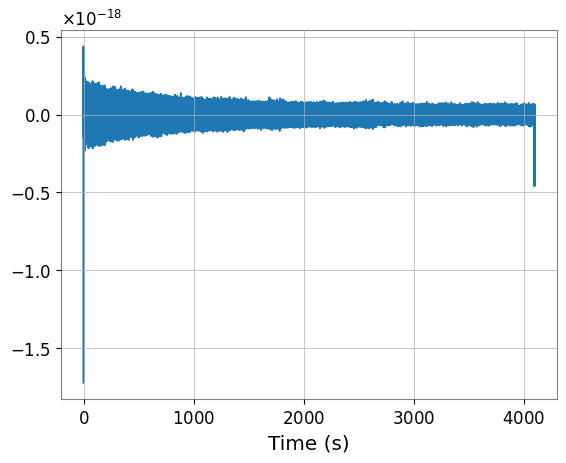

In [11]:
from pycbc.frame import read_frame
from pycbc.filter import highpass
import pylab

strain=read_frame('challenge3_2048hz.gwf','H1:CHALLENGE3')

#Suppress low frequency component that may produce numerical artefacts
strain=highpass(strain,15.0)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

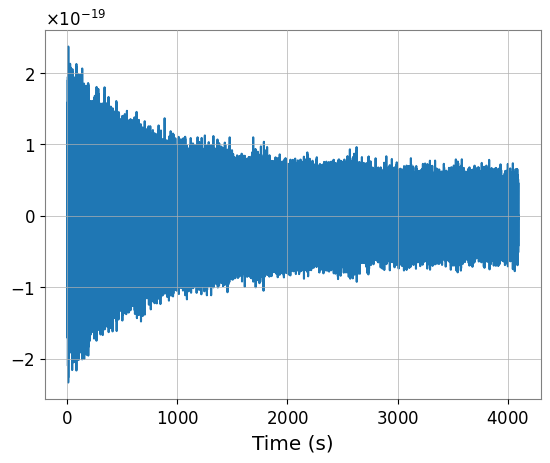

In [12]:
#Trim data to remove spikes
conditioned=strain.crop(2,2)
pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [13]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

#PSD via Welch's Method
psd=conditioned.psd(4)
psd=interpolate(psd, conditioned.delta_f)
psd=inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),low_frequency_cutoff=15)

In [14]:
from pycbc.waveform import get_td_waveform
m=10
hp, hc=get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)
hp.resize(len(conditioned))
template=hp.cyclic_time_shift(hp.start_time)

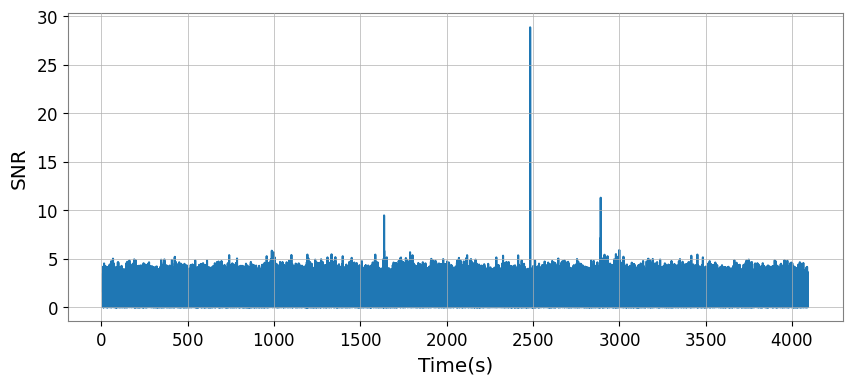

In [17]:
from pycbc.filter import matched_filter
import numpy
snr=matched_filter(template,conditioned,psd=psd,low_frequency_cutoff=20)

#4s at beginning and end for psd filtering, 4s for template length.
snr=snr.crop(8,4)
pylab.figure(figsize=[10,4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('SNR')
pylab.xlabel('Time(s)')
pylab.show()

In [29]:
#Significance test for 3 peaks

from pycbc.vetoes import power_chisq
nbins=30
chisq=power_chisq(hp,conditioned,nbins,psd,low_frequency_cutoff=20.0)
chisq=chisq.crop(10,10)
dof=nbins*2 - 2
chisq/=dof

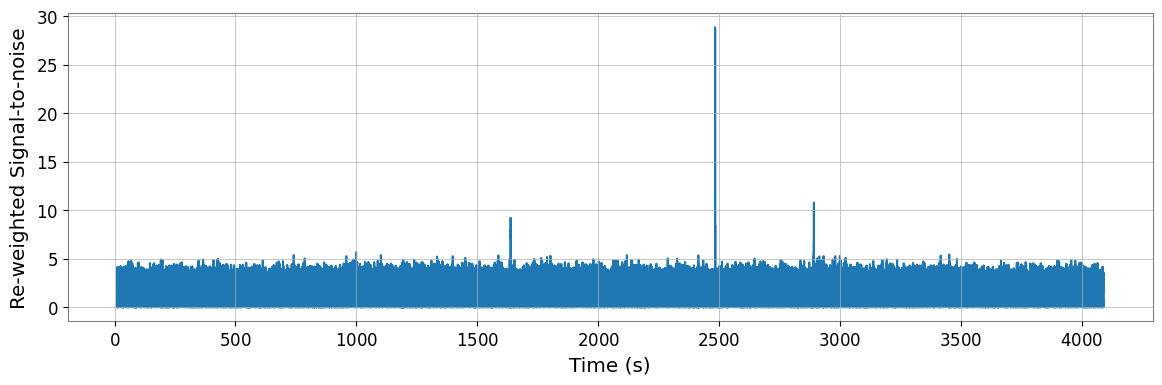

In [30]:
from pycbc.events.ranking import newsnr
nsnr=newsnr(abs(snr),chisq)
pylab.figure(figsize=[14,4])
pylab.plot(snr.sample_times,nsnr) 
pylab.xlabel('Time (s)')
pylab.ylabel('Re-weighted Signal-to-noise')
pylab.show()

In [33]:
peak=abs(nsnr).argmax()
nsnrp=nsnr[peak]
print(abs(nsnrp))

28.879127107611588
